In [1]:
import pprint
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import jax.random as rnd

master_key = rnd.PRNGKey(0)

# Numpyro
A probabilitic programming langugage in python based on `Pyro`, using a `numpy` backend and `jax` for auto-diff

A probabilistic program is made up of _stochastic functions_. These are python callables (i.e. have a `__call__()` method) which combine:

- deterministic Python code 
- primitive stochastic functions (which them selves call an RNG)

Let's start with a simple stochastic function:

In [2]:
fair_coin_dist = dist.Bernoulli(0.5)

# A stochastic function
def f():
    coin = numpyro.sample('coin', fair_coin_dist)  # a sample site
    return coin

# If this were just pyro, this would draw a sample:
# f()

In [3]:
master_key, sample_key = rnd.split(master_key)

# option 0: Sample from a distribution directly (not useful for inference):
flip0 = fair_coin_dist.sample(sample_key)

# option 1: pass seed explicitly (not very flexible):
flip1 = numpyro.sample('flip1', fair_coin_dist, rng_key=sample_key)

# option 2 use a "context manager":
with numpyro.handlers.seed(rng_seed=0):
    flip2 = numpyro.sample('flip2', fair_coin_dist)

# option 3 use a higher order function:
flip3 = numpyro.handlers.seed(f, rng_seed=0)()

flip0, flip1, flip2, flip3

(DeviceArray(1, dtype=int32),
 DeviceArray(1, dtype=int32),
 DeviceArray(1, dtype=int32),
 DeviceArray(1, dtype=int32))

With any of the above options, we can run our stochastic model forwards, given a `jax.PRNGKey` to get realisations of the random variables in the model.

## Primitives
A stochastic function in `numpyro` is made up of _primitives_ and _effect handlers_. The primitives can be thought of as parts of a DAG in a Bayesian model:

In [4]:
# Generalise
def flip():
    prob = numpyro.param('prob', 0.8)                    # a fixed parameter site
    coin = numpyro.sample('coin', dist.Bernoulli(prob))  # a sample site (i.e a random variable)
    return coin

def multi_flip():
    prob = numpyro.param('prob', 0.8)
    with numpyro.plate('i', 100):                    # also called a plate in DAGs - makes 100 indpendent variables
        coin = numpyro.sample("coin", dist.Bernoulli(prob))
    return coin

There is also a `scan` primitive to work with `jax.scan` but I haven't used that yet.

Simulate some data from the `multi_flip` model:

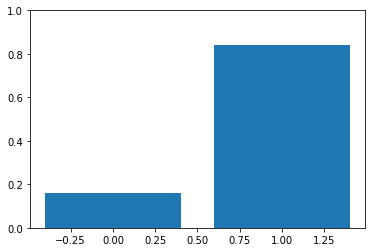

In [5]:
with numpyro.handlers.seed(multi_flip, sample_key):
    flips = multi_flip()
flips
plt.bar([0,1], [1-jnp.mean(flips),jnp.mean(flips)])
plt.ylim(0,1)
plt.show()

How does it work? `sample` is a function `sample(name, fn, ...)`. 
By default, `sample` calls its `fn` (passing in some argumnets) and returns the result (this is why it throws if you pass no `jax.RNGKey`)
If there is an active `numpyro` effect handler, then a **message** is returned instead.
These messages are dictionaries describing what the sample is: its name, its function, if its an observable, its value, etc.
This is how effect handlers can change the behaviour of `sample` sites (and `param`s and `plate`s etc.)


So when `multi_flip` is called in a usual context, the line `coin = numpyro.sample(...)` calls `dist.Bernoulli(prob)()` (which tries to sample using a `None` as a key).
However, when the call is wrapped `with` the `handler.seed` effect handler each `sample` site is called from `seed.process_message()` instead (using some cool python tricks).
Now, `sample` returns a dictionary including the keys `"fn":dist.Bernoulli(prob)` and `"rng_key":None` inside the `process_message` function, which then splits a new key and calls `fn` to generate an actual value.

Its the moral equivalent of:

In [6]:
def seed(model_callable, rng_key):
    for site in sample_statements(model_callable):
        rng_key, sample_key = split(rng_key)
        site['value'] = site['fn'](sample_key)
       

We can see the `trace` of what the handlers do by wrapping them in another handler called `trace`:

In [7]:
flip_trace = numpyro.handlers.trace(numpyro.handlers.seed(flip, sample_key)).get_trace()
flip_trace.keys()

odict_keys(['prob', 'coin'])

In [8]:
flip_trace['prob']

{'type': 'param',
 'name': 'prob',
 'fn': <function numpyro.util.identity(x, *args, **kwargs)>,
 'args': (0.8,),
 'kwargs': {},
 'value': 0.8,
 'scale': None,
 'cond_indep_stack': []}

In [9]:
flip_trace['coin']    

{'type': 'sample',
 'name': 'coin',
 'fn': <numpyro.distributions.discrete.BernoulliProbs at 0x7f75147daa00>,
 'args': (),
 'kwargs': {'rng_key': array([1190051861, 3378399878], dtype=uint32),
  'sample_shape': ()},
 'value': DeviceArray(0, dtype=int32),
 'scale': None,
 'is_observed': False,
 'intermediates': [],
 'cond_indep_stack': [],
 'infer': {}}

## Effect Handlers
We've seen how `seed` converts a `sample` statement to sub in an `rng_key`. Let's use some other handlers to make the `multi_flip` model amenable to inference.

`multi_flip` is currently a simple forward model, it describes how to generate the array `flips` from a fixed `prob`ability. 
To perform inference on `prob`, first we need to **lift** it by assigning a prior:

In [10]:
lifted = numpyro.handlers.lift(multi_flip, prior={'prob': dist.Beta(2, 2)})

lifted_trace = numpyro.handlers.trace(numpyro.handlers.seed(lifted, 0)).get_trace()

lifted_trace['prob'] # Note its now a sample site!

{'type': 'sample',
 'name': 'prob',
 'fn': <numpyro.distributions.continuous.Beta at 0x7f751dda0fd0>,
 'args': (),
 'kwargs': {'rng_key': array([2718843009, 1272950319], dtype=uint32),
  'sample_shape': ()},
 'value': DeviceArray(0.9372851, dtype=float32),
 'scale': None,
 'cond_indep_stack': [],
 'intermediates': [],
 'is_observed': False}

I will now treat the simulated `flips` variable as data for the `coin`s. This is `condition`ing:

In [11]:
posterior = numpyro.handlers.condition(lifted, {'coin': flips})

posterior_trace = numpyro.handlers.trace(
    numpyro.handlers.seed(posterior, 0)).get_trace()

pprint.pprint(posterior_trace['coin'])

{'args': (),
 'cond_indep_stack': [CondIndepStackFrame(name='i', dim=-1, size=100)],
 'fn': <numpyro.distributions.distribution.ExpandedDistribution object at 0x7f75682bf610>,
 'infer': {},
 'intermediates': [],
 'is_observed': True,
 'kwargs': {'rng_key': None, 'sample_shape': ()},
 'name': 'coin',
 'scale': None,
 'type': 'sample',
 'value': DeviceArray([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
             1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
             1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
             1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],            dtype=int32)}


We now have a callable which has the value of `coin` set to the data `flips` and has a Beta(2, 2) prior set to `prob`. To use this for inference, we need to compute the log_density for some value of `prob`. That is, a way to `substitute` a value for `prob`:


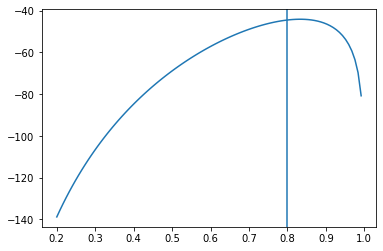

In [12]:
def log_prob(posterior, p):
    trace = numpyro.handlers.trace(numpyro.handlers.substitute(posterior, {'prob': p})).get_trace()
    logp = 0.0
    for site in trace.values():
        if site['type'] == "sample":
            logp = logp + jnp.sum(site['fn'].log_prob(site['value']))
    return logp
    
    

probs = jnp.linspace(0.2, 1.0, 100)
lps = [log_prob(posterior, p) for p in probs]

plt.plot(probs, lps)
plt.axvline(0.8)
plt.show()

# Bijectors
TFP has the `bijectors` library to make it easy to transform variables in a model to the real-line which is vital for HMC, all while preserving measure. 
I wanted a similar feature in `numpyro` by writing an effect handler.

All `numpyro.distribution`s know their support, and there is a global map of constraints/supports to bijection functions. We can use this to add a `transform` key to the sample sites during a model trace:

In [13]:
from numpyro.primitives import Messenger
from numpyro.distributions.transforms import biject_to
from numpyro.distributions.util import sum_rightmost

class substitute_unconstrained(Messenger):
    def __init__(self, fn=None, data=None, substitute_fn=None):
        self.substitute_fn = substitute_fn
        self.data = data
        if ((data is None) == (substitute_fn is None)):
            raise ValueError('At least one of `data` or `substitute_fn` should be provided.')
        super(substitute_unconstrained, self).__init__(fn)

    def process_message(self, msg):
        # if its not a sample or its observed, do nothing
        if not msg['type'] == 'sample':
            return
        if msg['is_observed']:
            return
        # get the value for this site from the dictionary or function
        if self.data is not None:
            unconstrained_value = self.data.get(msg['name'])
        else:
            unconstrained_value = self.substitute_fn(msg)

        if unconstrained_value is not None:
            fn = msg['fn']
            transform = biject_to(fn.support) # dist's know their support
            value = transform(unconstrained_value)
            # log jacobian term
            logdet = transform.log_abs_det_jacobian(unconstrained_value, value)
            # shape twiddling
            logdet = sum_rightmost(logdet, jnp.ndim(logdet) - jnp.ndim(value) + len(fn.event_shape))
            # a factor just adds an arbitary value which will get summed up in the log_probability
            numpyro.factor("_{}_logdet".format(
                msg['name']), jnp.array((logdet,)))
            msg['value'] = value

In [14]:
on_reals_trace = numpyro.handlers.trace(substitute_unconstrained(posterior, {'prob':-1.0})).get_trace()

on_reals_trace['prob']

{'type': 'sample',
 'name': 'prob',
 'fn': <numpyro.distributions.continuous.Beta at 0x7f751dda0fd0>,
 'args': (),
 'kwargs': {'rng_key': None, 'sample_shape': ()},
 'value': DeviceArray(0.26894143, dtype=float32),
 'scale': None,
 'cond_indep_stack': [],
 'intermediates': [],
 'is_observed': False}

We can use this to define a generic potential energy function which takes a callable and dictionary keyed by site name to compute the potential energy:

In [15]:
def potential(posterior, x):
    """@param x dictionary of unconstrained value with same site names as sample sites in posterior"""
    trace = numpyro.handlers.trace(substitute_unconstrained(posterior, x)).get_trace()
    logp = 0.0
    for site in trace.values():
        if site['type'] == "sample":
            logp = logp + jnp.sum(site['fn'].log_prob(site['value']))
    return logp


# could use partial here...
def f(x):
    return potential(posterior, {'prob': x})


g = jax.grad(f)


f(-1.0), g(-1.0)

(DeviceArray(-116.787445, dtype=float32),
 DeviceArray(58.030083, dtype=float32))

In [16]:
# Now we could use gradient ascent or HMC to perform inference on prob...
log_prob(posterior, 0.2689)

DeviceArray(-115.17306, dtype=float32)